In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.multitest import multipletests
import seaborn as sns

# Load Data

In [2]:
cell_profiler_metrics = pd.read_csv("path/to/cellprofiler/output/morphometrics/3_cellprofiler/output/MyExpt_SomaAndNeuritesMerged.csv")
cell_profiler_soma = pd.read_csv("path/to/cellprofiler/output/morphometrics/3_cellprofiler/output/MyExpt_soma.csv")
cell_profiler_skeleton = pd.read_csv("path/to/cellprofiler/output/morphometrics/3_cellprofiler/output/MyExpt_SomaAndSkelNeuritesMerged.csv")



In [3]:
data_dir = Path("cellpose_transcripts_opposite_lyso")

all_files = sorted(data_dir.glob("*.csv"))

dfs = [pd.read_csv(f, index_col=0) for f in all_files]

combined_df = pd.concat(dfs, axis=0)

In [4]:
top4 = ['ID2-4', 'SOX5-3', 'NFIB-2', 'ID2-2']
sgRNA_genes = [gene for gene in combined_df.columns if '-' in gene and not 'HLA' in gene]
sgRNA_cols = [
    col for col in sgRNA_genes
    if col not in top4
]

gene_names = sorted({col.split("-", 1)[0] for col in sgRNA_cols})
perturb_df = pd.DataFrame(index=combined_df.index, columns=gene_names, dtype="object")
for gene in gene_names:
    matching_cols = [col for col in sgRNA_cols if col.startswith(gene + "-")]
    if not matching_cols:
        continue

    sub_df = combined_df[matching_cols]
    any_positive = (sub_df > 0).any(axis=1)
    perturb_df[gene] = any_positive.map({True: "perturbed", False: "unperturbed"})

# Filter pd df

In [5]:
Suggested_feature = [
    'ImageNumber',
    'ObjectNumber',
    'Intensity_MeanIntensity_BFP',
    'Intensity_MADIntensity_BFP',
    'RadialDistribution_MeanFrac_BFP_3of4',
    'AreaShape_Extent',
    'AreaShape_Compactness',
    'AreaShape_Solidity',
    'AreaShape_MajorAxisLength',
    'AreaShape_MinorAxisLength',
    'AreaShape_MaxFeretDiameter',
    'AreaShape_Orientation',
    'AreaShape_Eccentricity',
    'AreaShape_Area',
    'AreaShape_Perimeter',
    'Texture_Entropy_BFP_3_00_256'
]

In [6]:
cell_profiler_metrics_filtered = cell_profiler_metrics[cell_profiler_metrics['AreaShape_Area']>1000]
cell_profiler_metrics_filtered = cell_profiler_metrics_filtered[cell_profiler_metrics_filtered['AreaShape_Eccentricity']>0.4]
cell_profiler_metrics_filtered = cell_profiler_metrics_filtered[Suggested_feature]


In [7]:
cell_profiler_metrics_filtered['cell_id'] = (
    cell_profiler_metrics_filtered['ImageNumber'].astype(str)
    + '_'
    + cell_profiler_metrics_filtered['ObjectNumber'].astype(str)
)

In [8]:
cell_profiler_metrics_filtered

,ImageNumber,ObjectNumber,Intensity_MeanIntensity_BFP,Intensity_MADIntensity_BFP,RadialDistribution_MeanFrac_BFP_3of4,AreaShape_Extent,AreaShape_Compactness,AreaShape_Solidity,AreaShape_MajorAxisLength,AreaShape_MinorAxisLength,AreaShape_MaxFeretDiameter,AreaShape_Orientation,AreaShape_Eccentricity,AreaShape_Area,AreaShape_Perimeter,Texture_Entropy_BFP_3_00_256,cell_id
0,1,1,0.001931,0.000275,1.021140,0.728009,1.263112,0.969183,87.211203,57.108258,91.241438,46.361209,0.755779,3774,244.752309,-0.0,1_1
4,1,5,0.001689,0.000061,1.011477,0.751843,1.140856,0.968354,43.438427,35.990153,43.416587,89.816791,0.559941,1224,132.468037,0.0,1_5
5,1,6,0.001608,0.000046,1.002471,0.336332,5.711028,0.544313,249.548731,74.837024,251.127458,-89.894369,0.953974,7628,739.890440,0.0,1_6
6,1,7,0.001732,0.000061,1.093531,0.336714,5.981730,0.522070,252.256555,80.673157,249.393264,-0.257262,0.947483,7901,770.653896,-0.0,1_7
7,1,8,0.001674,0.000061,1.023049,0.522350,2.610254,0.701983,125.595007,72.881807,146.184815,-23.349893,0.814408,5983,443.002092,-0.0,1_8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123033,480,98,0.002051,0.000137,1.059208,0.286622,4.802580,0.502244,113.069040,62.865086,129.034879,-43.651859,0.831190,3021,426.989899,-0.0,480_98
123034,480,99,0.001917,0.000092,1.013944,0.501187,2.005167,0.823529,90.015572,41.442949,90.785461,53.424218,0.887713,2534,252.687338,-0.0,480_99
123035,480,100,0.002039,0.000137,0.992841,0.678646,1.324405,0.925426,44.535899,38.699754,49.648766,73.462102,0.494889,1303,147.260931,-0.0,480_100
123036,480,101,0.002014,0.000107,1.134646,0.324982,4.614266,0.507499,114.658218,81.642166,112.645462,-29.163593,0.702131,3113,424.859956,-0.0,480_101


# Run Comparisons

In [9]:
perturb_df_filtered = perturb_df[perturb_df.index.isin(cell_profiler_metrics_filtered['cell_id'])]
cell_profiler_metrics_filtered = cell_profiler_metrics_filtered[cell_profiler_metrics_filtered['cell_id'].isin(perturb_df.index)]


In [10]:
Suggested_feature = [
    'ImageNumber',
    'ObjectNumber',
    'ObjectSkeleton_NumberBranchEnds_neurite_binary',
    'ObjectSkeleton_NumberNonTrunkBranches_neurite_binary',
    'ObjectSkeleton_NumberTrunks_neurite_binary',
    'ObjectSkeleton_TotalObjectSkeletonLength_neurite_binary',
    'Neighbors_AngleBetweenNeighbors_neurite_Expanded',
    'Neighbors_FirstClosestDistance_neurite_Expanded',
    'Neighbors_FirstClosestObjectNumber_neurite_Expanded',
    'Neighbors_NumberOfNeighbors_neurite_Expanded',
    'Neighbors_PercentTouching_neurite_Expanded',
    'Neighbors_SecondClosestDistance_neurite_Expanded',
    'Neighbors_SecondClosestDistance_neurite_Expanded'
]

In [11]:
cell_profiler_soma_filtered = cell_profiler_soma[cell_profiler_soma['AreaShape_Area']>1000]
cell_profiler_soma_filtered = cell_profiler_soma_filtered[cell_profiler_soma_filtered['AreaShape_Eccentricity']>0.4]

cell_profiler_soma_filtered['cell_id'] = (
    cell_profiler_soma_filtered['ImageNumber'].astype(str)
    + '_'
    + cell_profiler_soma_filtered['ObjectNumber'].astype(str)
)
cell_profiler_soma_filtered = cell_profiler_soma_filtered[Suggested_feature+['cell_id']]
cell_profiler_soma_filtered['neurite_count_connect'] = cell_profiler_soma_filtered['ObjectSkeleton_NumberNonTrunkBranches_neurite_binary'] +cell_profiler_soma_filtered['ObjectSkeleton_NumberTrunks_neurite_binary']


In [12]:
cell_profiler_filtered_combined = cell_profiler_metrics_filtered.merge(cell_profiler_soma_filtered, on="cell_id", how="inner")


   gene                                                  metric  n_perturbed  n_control  mean_perturbed  mean_control  t_p_raw  t_p_adj  u_p_raw  u_p_adj
   ISL1                                      AreaShape_Solidity         1811       2694        0.720136      0.735140 0.002496 0.044932 0.002843 0.040939
ONECUT1                                          AreaShape_Area         3302       2630     7381.487280   7068.104183 0.006068 0.072813 0.001827 0.034373
ONECUT1                                      AreaShape_Solidity         3302       2630        0.719622      0.736109 0.000118 0.008518 0.000143 0.010260
ONECUT1 ObjectSkeleton_TotalObjectSkeletonLength_neurite_binary         3302       2630      323.901988    300.840793 0.002345 0.044932 0.000581 0.020912
ONECUT2                                      AreaShape_Solidity         1896       2671        0.718278      0.735182 0.000622 0.022388 0.001910 0.034373


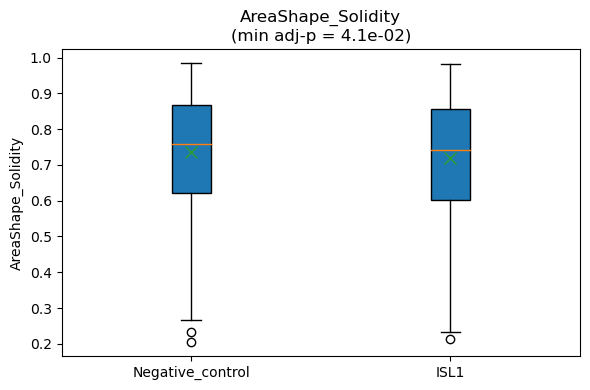

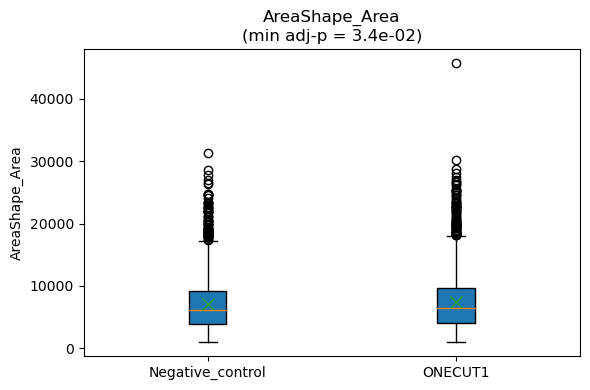

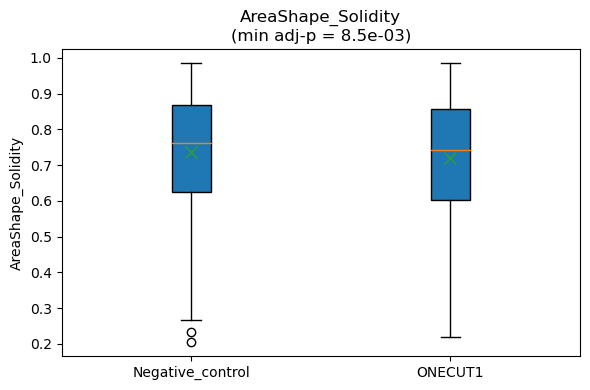

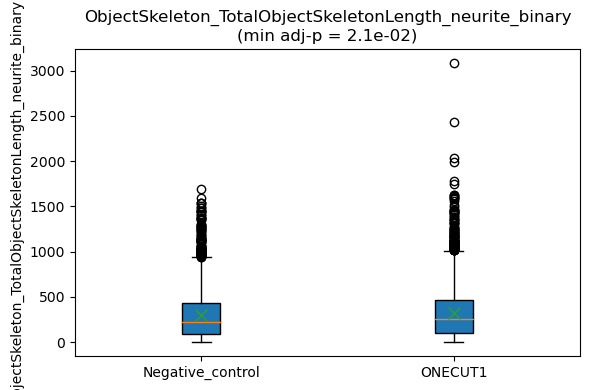

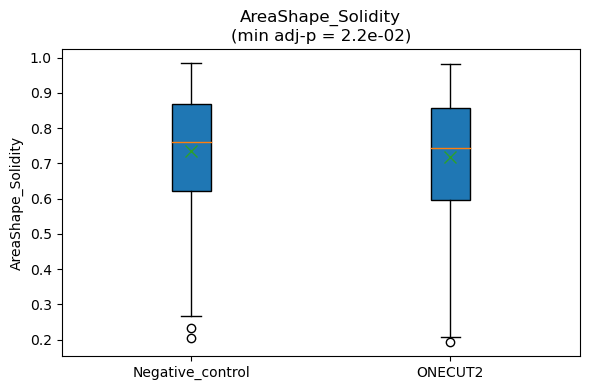

In [13]:
metrics = ["AreaShape_Area", "AreaShape_Solidity", "ObjectSkeleton_TotalObjectSkeletonLength_neurite_binary"]

genes = [g for g in perturb_df.columns if g != "Negative_control"]
alpha = 0.05

df_all = cell_profiler_filtered_combined.merge(
    perturb_df,
    left_on="cell_id",
    right_index=True,
    how="inner"
)

records = []
for gene in genes:
    sub = df_all[
        ((df_all[gene] == "perturbed") | (df_all["Negative_control"] == "perturbed"))
        & ~((df_all[gene] == "perturbed") & (df_all["Negative_control"] == "perturbed"))
    ]
    for col in metrics:
        a = sub.loc[sub[gene] == "perturbed", col].dropna().values
        b = sub.loc[sub["Negative_control"] == "perturbed", col].dropna().values
        
        n_pr, n_nc = len(a), len(b)
        mean_pr = a.mean() if n_pr else np.nan
        mean_nc = b.mean() if n_nc else np.nan
        
        _, t_p = ttest_ind(a, b, nan_policy="omit", equal_var=True)
        _, u_p = mannwhitneyu(a, b, alternative="two-sided")
        
        records.append({
            "gene": gene,
            "metric": col,
            "n_perturbed": n_pr,
            "n_control": n_nc,
            "mean_perturbed": mean_pr,
            "mean_control": mean_nc,
            "t_p_raw": t_p,
            "u_p_raw": u_p
        })

results = pd.DataFrame.from_records(records)

results["t_p_adj"] = multipletests(results["t_p_raw"], alpha=alpha, method="fdr_bh")[1]
results["u_p_adj"] = multipletests(results["u_p_raw"], alpha=alpha, method="fdr_bh")[1]

mask = (results["t_p_adj"] < alpha) | (results["u_p_adj"] < alpha)
sig = results[mask].copy()

if sig.empty:
    print("No significant gene–metric comparisons found.")
else:
    print(sig.to_string(index=False, columns=[
        "gene", "metric", "n_perturbed", "n_control",
        "mean_perturbed","mean_control",
        "t_p_raw","t_p_adj","u_p_raw","u_p_adj"
    ]))

for _, row in sig.iterrows():
    gene = row["gene"]
    col  = row["metric"]
    smallest_p = min(row["t_p_adj"], row["u_p_adj"])
    
    sub = df_all[
        ((df_all[gene] == "perturbed") | (df_all["Negative_control"] == "perturbed"))
        & ~((df_all[gene] == "perturbed") & (df_all["Negative_control"] == "perturbed"))
    ]
    data_pr = sub.loc[sub[gene] == "perturbed", col]
    data_nc = sub.loc[sub["Negative_control"] == "perturbed", col]
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.boxplot(
        [data_nc, data_pr],
        labels=["Negative_control", gene],
        patch_artist=True,
        showmeans=True,
        meanprops=dict(marker="x", markersize=8)
    )
    ax.grid(False)
    ax.set_title(f"{col}\n(min adj-p = {smallest_p:.1e})")
    ax.set_ylabel(col)
    plt.tight_layout()
    plt.show()


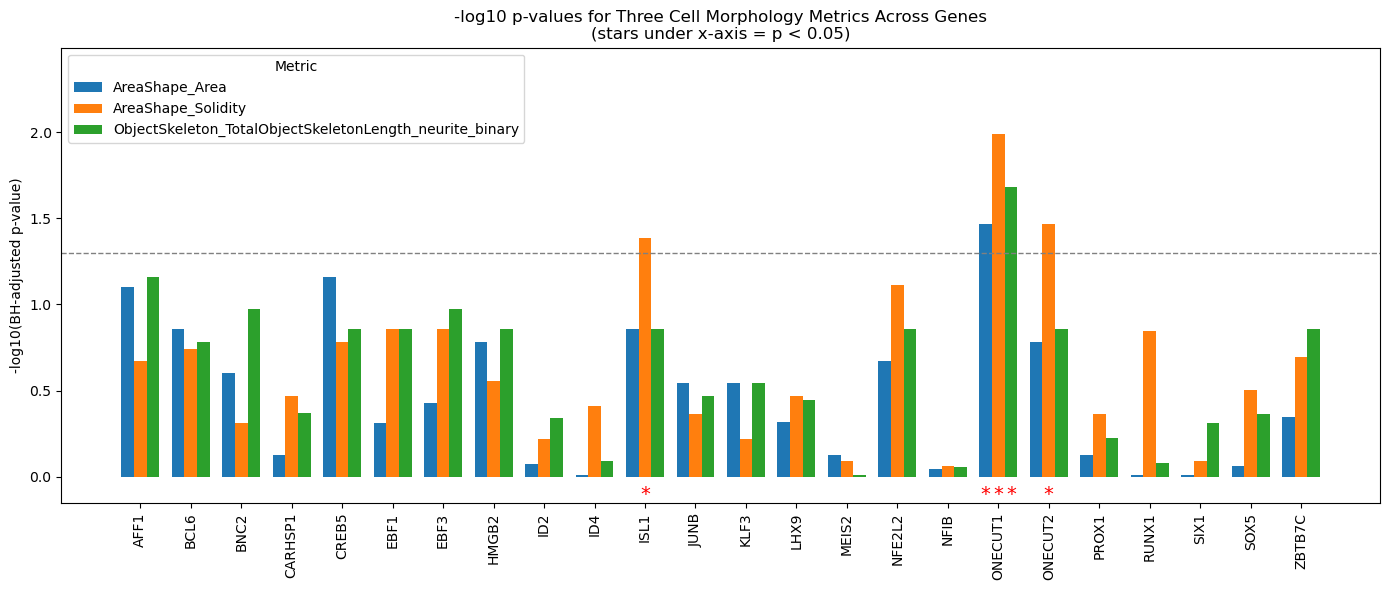

In [15]:
metrics3 = ["AreaShape_Area", "AreaShape_Solidity", "ObjectSkeleton_TotalObjectSkeletonLength_neurite_binary"]
alpha    = 0.05

df3   = results[results["metric"].isin(metrics3)]
pivot = df3.pivot(index="gene", columns="metric", values="u_p_adj")[metrics3]

neglog = -np.log10(pivot)

genes = pivot.index.tolist()
x     = np.arange(len(genes))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
for i, metric in enumerate(metrics3):
    ax.bar(
        x + i*width,
        neglog[metric],
        width,
        label=metric
    )

threshold = -np.log10(alpha)
ax.axhline(threshold, color="gray", linestyle="--", linewidth=1)

ax.set_ylim(-0.15, neglog.values.max() + 0.5)

for i, metric in enumerate(metrics3):
    for j, gene in enumerate(genes):
        p = pivot.loc[gene, metric]
        if p < alpha:
            xpos = x[j] + i*width
            ax.text(
                xpos,
                -0.1,
                "*",
                ha="center",
                va="center",
                color="red",
                fontsize=14
            )

ax.set_xticks(x + width)
ax.set_xticklabels(genes, rotation=90)
ax.set_ylabel("-log10(BH-adjusted p-value)")
ax.set_title("-log10 p-values for Three Cell Morphology Metrics Across Genes\n(stars under x-axis = p < 0.05)")
ax.legend(title="Metric")
plt.tight_layout()

#fig.savefig("barplot_3metrics_neglogp_stars_under_xaxis_morph.png", dpi=300, bbox_inches="tight")
plt.show()


   gene                                                  metric  n_perturbed  n_control  mean_perturbed  mean_control  t_p_raw  t_p_adj  u_p_raw  u_p_adj
   ISL1                                      AreaShape_Solidity         1811       2694        0.720136      0.735140 0.002496 0.044932 0.002843 0.040939
ONECUT1                                          AreaShape_Area         3302       2630     7381.487280   7068.104183 0.006068 0.072813 0.001827 0.034373
ONECUT1                                      AreaShape_Solidity         3302       2630        0.719622      0.736109 0.000118 0.008518 0.000143 0.010260
ONECUT1 ObjectSkeleton_TotalObjectSkeletonLength_neurite_binary         3302       2630      323.901988    300.840793 0.002345 0.044932 0.000581 0.020912
ONECUT2                                      AreaShape_Solidity         1896       2671        0.718278      0.735182 0.000622 0.022388 0.001910 0.034373


/home/mingjiay/miniconda3/envs/scanpy0923/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mingjiay/miniconda3/envs/scanpy0923/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/mingjiay/miniconda3/envs/scanpy0923/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


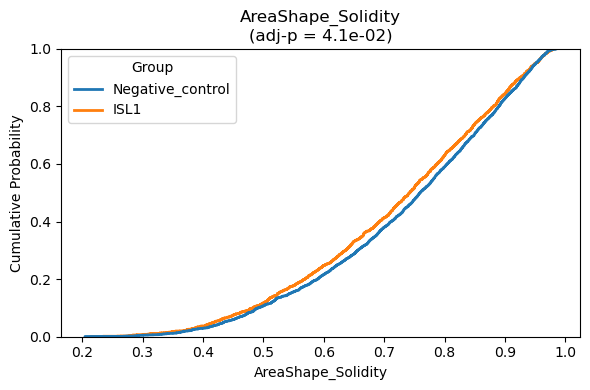

/home/mingjiay/miniconda3/envs/scanpy0923/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mingjiay/miniconda3/envs/scanpy0923/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/mingjiay/miniconda3/envs/scanpy0923/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


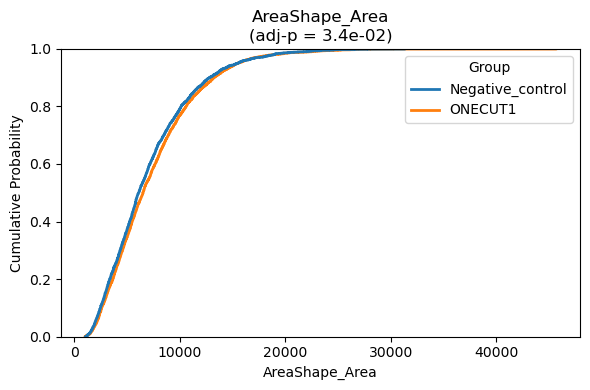

/home/mingjiay/miniconda3/envs/scanpy0923/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mingjiay/miniconda3/envs/scanpy0923/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/mingjiay/miniconda3/envs/scanpy0923/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


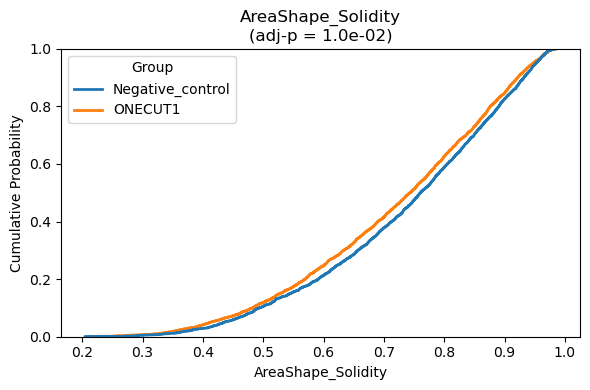

/home/mingjiay/miniconda3/envs/scanpy0923/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mingjiay/miniconda3/envs/scanpy0923/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/mingjiay/miniconda3/envs/scanpy0923/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


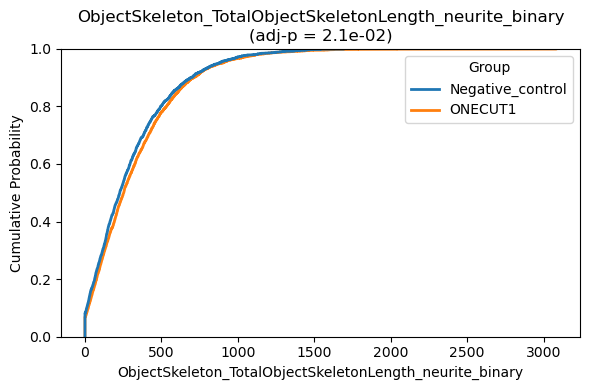

/home/mingjiay/miniconda3/envs/scanpy0923/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mingjiay/miniconda3/envs/scanpy0923/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/mingjiay/miniconda3/envs/scanpy0923/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


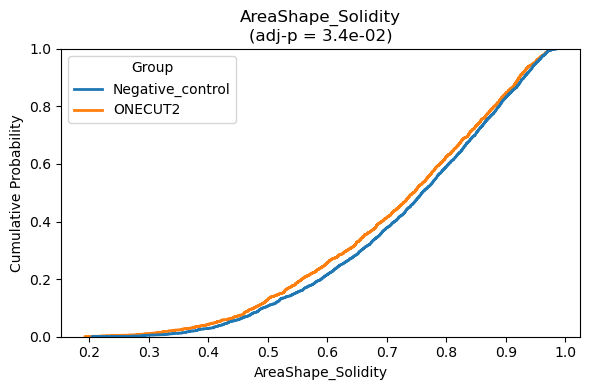

In [16]:
metrics = ["AreaShape_Area", "AreaShape_Solidity", "ObjectSkeleton_TotalObjectSkeletonLength_neurite_binary"]

genes = [g for g in perturb_df.columns if g != "Negative_control"]
alpha = 0.05

df_all = cell_profiler_filtered_combined.merge(
    perturb_df,
    left_on="cell_id",
    right_index=True,
    how="inner"
)

records = []
for gene in genes:
    sub = df_all[
        ((df_all[gene] == "perturbed") | (df_all["Negative_control"] == "perturbed"))
        & ~((df_all[gene] == "perturbed") & (df_all["Negative_control"] == "perturbed"))
    ]
    for col in metrics:
        a = sub.loc[sub[gene] == "perturbed", col].dropna().values
        b = sub.loc[sub["Negative_control"] == "perturbed", col].dropna().values
        
        n_pr, n_nc = len(a), len(b)
        mean_pr = a.mean() if n_pr else np.nan
        mean_nc = b.mean() if n_nc else np.nan
        
        _, t_p = ttest_ind(a, b, nan_policy="omit", equal_var=True)
        _, u_p = mannwhitneyu(a, b, alternative="two-sided")
        
        records.append({
            "gene": gene,
            "metric": col,
            "n_perturbed": n_pr,
            "n_control": n_nc,
            "mean_perturbed": mean_pr,
            "mean_control": mean_nc,
            "t_p_raw": t_p,
            "u_p_raw": u_p
        })

results = pd.DataFrame.from_records(records)

results["t_p_adj"] = multipletests(results["t_p_raw"], alpha=alpha, method="fdr_bh")[1]
results["u_p_adj"] = multipletests(results["u_p_raw"], alpha=alpha, method="fdr_bh")[1]

mask = (results["t_p_adj"] < alpha) | (results["u_p_adj"] < alpha)
sig = results[mask].copy()

if sig.empty:
    print("No significant gene–metric comparisons found.")
else:
    print(sig.to_string(index=False, columns=[
        "gene", "metric", "n_perturbed", "n_control",
        "mean_perturbed","mean_control",
        "t_p_raw","t_p_adj","u_p_raw","u_p_adj"
    ]))

for _, row in sig.iterrows():
    gene = row["gene"]
    col  = row["metric"]
    smallest_p = row["u_p_adj"]
    
    sub = df_all[
        ((df_all[gene] == "perturbed") | (df_all["Negative_control"] == "perturbed"))
        & ~((df_all[gene] == "perturbed") & (df_all["Negative_control"] == "perturbed"))
    ]
    
    data_pr = sub.loc[sub[gene] == "perturbed", col].dropna()
    data_nc = sub.loc[sub["Negative_control"] == "perturbed", col].dropna()
    
    df_plot = pd.DataFrame({
        col: np.concatenate([data_nc.values, data_pr.values]),
        "Group": (["Negative_control"] * len(data_nc)) + ([gene] * len(data_pr))
    })
    
    plt.figure(figsize=(6, 4))
    sns.ecdfplot(data=df_plot, x=col, hue="Group", linewidth=2)
    plt.title(f"{col}\n(adj-p = {smallest_p:.1e})")
    plt.xlabel(col)
    plt.ylabel("Cumulative Probability")
    plt.grid(False)
    plt.tight_layout()
    plt.show()
